In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import keras
from keras import layers, models, datasets
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzip small_data.zip
!unzip /content/drive/MyDrive/Master_Thesis/small_data.zip

Archive:  /content/drive/MyDrive/Master_Thesis/small_data.zip
  inflating: small_data.npy          


In [4]:
path = '/content/drive/MyDrive/Master_Thesis'

# read small_data.npy and all_target.csv
small_data = np.load("small_data.npy")
all_target = pd.read_csv(f"{path}/all_target.csv")

In [5]:
small_data.shape

(81, 10, 512, 512)

Image shape: (512, 512)




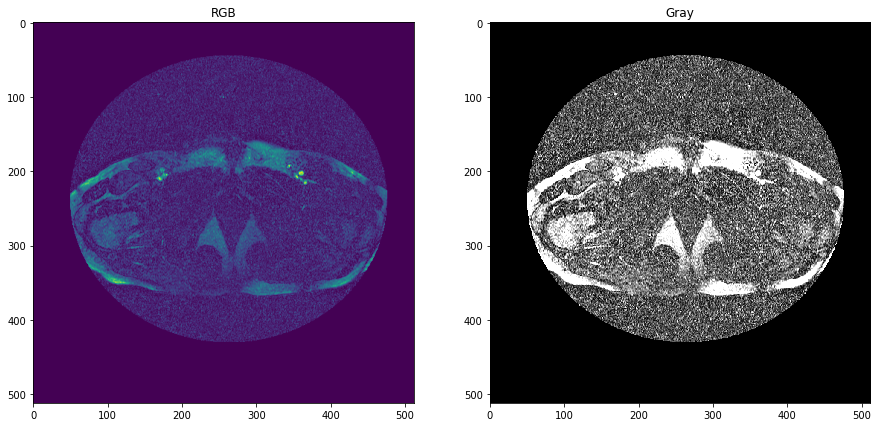

In [6]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib.image as img

patient_images = small_data[0]
print(f"Image shape: {patient_images[0].shape}\n\n")

nRow = 1
nCol = 2
fig, axis = plt.subplots(nRow, nCol, figsize=(15, 8))

axis[0].imshow(patient_images[0])
axis[0].title.set_text('RGB')

axis[1].imshow(patient_images[0], cmap='gray', vmin=0, vmax=255, interpolation='none')
axis[1].title.set_text('Gray')

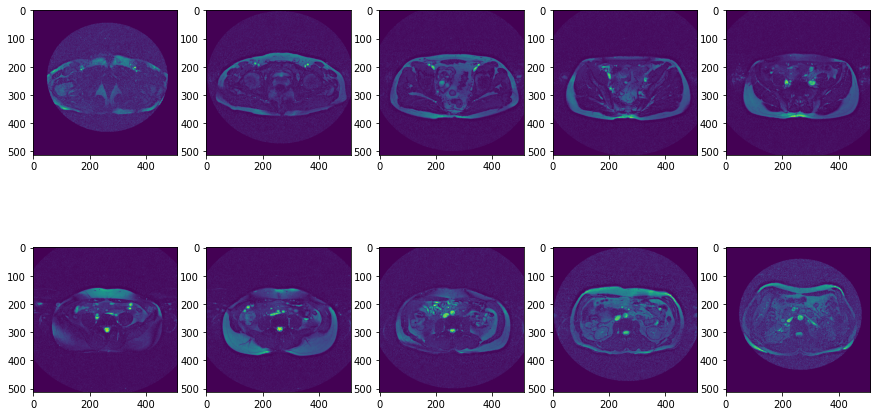

In [7]:
nRows = 2
nCols = 5
fig, axis = plt.subplots(nRows, nCols, figsize=(15, 8))
for row in range(nRows):
  for col in range(nCols):
    axis[row][col].imshow(patient_images[row*nCols+col])

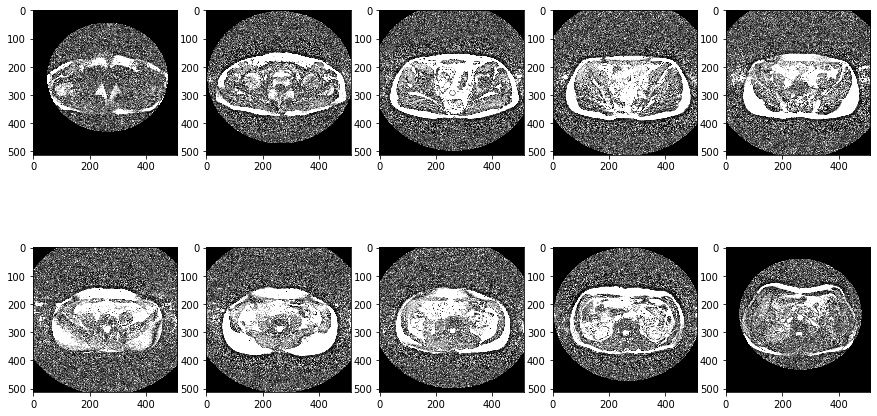

In [8]:
nRows = 2
nCols = 5
fig, axis = plt.subplots(nRows, nCols, figsize=(15, 8))
for row in range(nRows):
  for col in range(nCols):
    axis[row][col].imshow(patient_images[row*nCols+col], cmap='gray', vmin = 0, vmax = 255, interpolation='none')

In [9]:
# Each patient has 10 MRI images with the same class

#small_data = np.reshape(small_data, (810, 512, 512))

all_data = []
all_data_targets = []
for patient in range(small_data.shape[0]):
  for img in range(small_data.shape[1]):
    all_data.append(small_data[patient][img])
    all_data_targets.append(all_target['CEAP'][patient])

all_data = np.array(all_data)
all_data_targets = pd.DataFrame(all_data_targets)
all_data_targets.columns = ['CEAP']

all_data.shape

(810, 512, 512)

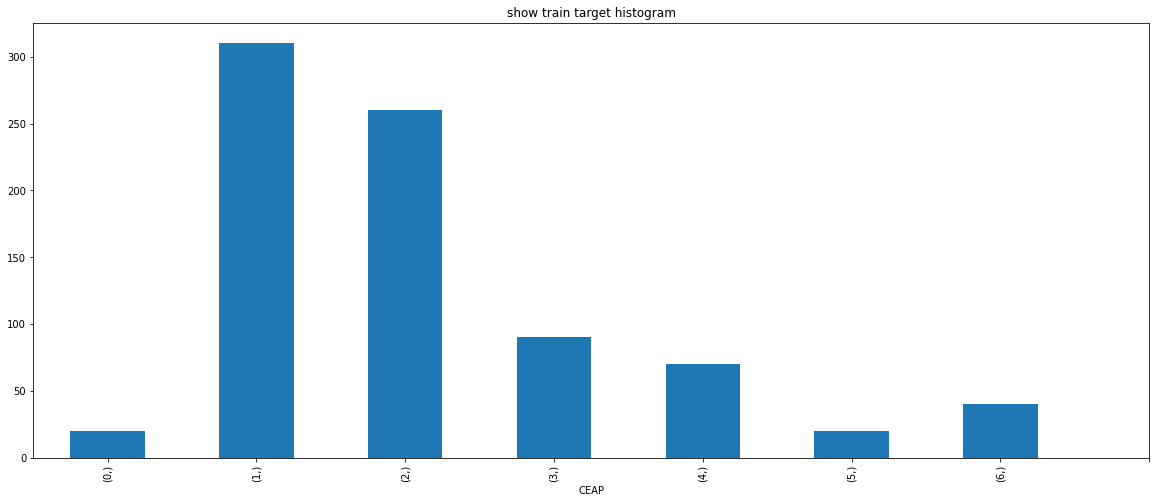

In [10]:
plt.figure(figsize=(20,8))
ax = all_data_targets.value_counts(sort=False).plot(kind='bar',title='show train target histogram')
ax.set_xticks(range(0,8))
#ax.set_xticklabels(LABELS)
plt.show()

# **First CNN Model**

In [11]:
## One-hot encoding of the categorical targets
all_targets_onehot = pd.DataFrame(np_utils.to_categorical(all_data_targets, 7))

In [12]:
# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(all_data, all_targets_onehot, test_size=0.3, random_state=42, shuffle=True)

x_tra, x_val, y_tra, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=12, shuffle=True)

In [13]:
# Calculate the class_weight
# Because our data is highly imbalance

class_weight ={}
for i in range(0,7):
    class_weight[i] = (sum(y_tra.iloc[:,1]) + sum(y_val.iloc[:,1])) / (sum(y_tra.iloc[:,i]) + sum(y_val.iloc[:,i]))
class_weight

{0: 15.785714285714286,
 1: 1.0,
 2: 1.2209944751381216,
 3: 3.25,
 4: 5.0227272727272725,
 5: 17.0,
 6: 8.5}

### Augmenting Train Data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import os
from PIL import Image
import imutils

aug_all_data = []
aug_all_data_targets = []
for i in range(len(all_data)):
  img = all_data[i]
  
  aug_all_data.append(img)
  aug_all_data_targets.append(all_data_targets['CEAP'][i])

  aug_all_data.append(imutils.rotate(img, 35))
  aug_all_data_targets.append(all_data_targets['CEAP'][i])

  aug_all_data.append(imutils.rotate(img, 85))
  aug_all_data_targets.append(all_data_targets['CEAP'][i])

aug_all_data = np.array(aug_all_data)
aug_all_data_targets = pd.DataFrame(aug_all_data_targets)
aug_all_data_targets.columns = ['CEAP']

aug_all_data.shape

(2430, 512, 512)

In [ ]:
from keras.layers import Conv2D, Input, Flatten, Dense, GaussianNoise
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling2D, BatchNormalization, LSTM, MaxPooling2D

cnn_ = models.Sequential()
cnn_.add(Input(shape=(512, 512, 1)))
cnn_.add(GaussianNoise(0.2))

cnn_.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_.add(BatchNormalization())
cnn_.add(MaxPooling2D(3))

cnn_.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
cnn_.add(BatchNormalization())
cnn_.add(MaxPooling2D(3))

cnn_.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
cnn_.add(BatchNormalization())
cnn_.add(MaxPooling2D(3))

cnn_.add(GlobalAveragePooling2D())
cnn_.add(Dropout(0.5))

cnn_.add(Flatten())
cnn_.add(Dense(16, activation='relu'))
cnn_.add(Dense(7, activation='softmax'))


cnn_.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_5 (GaussianN  (None, 512, 512, 1)      0         
 oise)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 510, 510, 64)      640       
                                                                 
 batch_normalization_18 (Bat  (None, 510, 510, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 170, 170, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 168, 168, 32)      18464     
                                                      

In [ ]:
cnn_.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_2 = cnn_.fit(x_tra, y_tra, validation_data=(x_val, y_val), epochs=20, class_weight=class_weight)

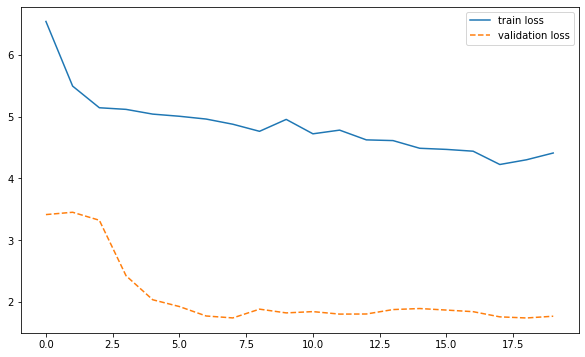

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'], '--')
plt.legend(['train loss', 'validation loss'])

### Prediction

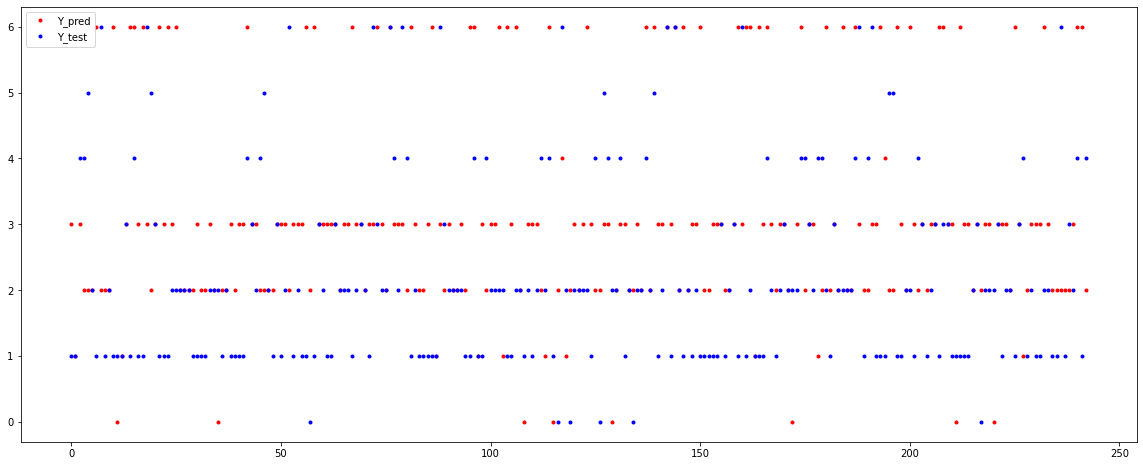

In [ ]:
pred = pd.DataFrame(cnn_.predict(X_test))

x = [ i for i in range(0,243)]
plt.figure(figsize=(20,8))
plt.plot(x,  np.argmax(pred.values ,axis=1), '.r')
plt.plot(x,  np.argmax(y_test.values ,axis=1), '.b')
plt.legend([ 'Y_pred', 'Y_test'])

# **Pre-Trained Model**

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD

import glob
import cv2
import os
import json
import shutil
from PIL import Image
from imageio import imread
import imutils

### Data Preparation

In [12]:
# Store images to folders
class_name = ['0', '1', '2', '3', '4', '5', '6']
path = "./Cardiovascular"

for i in range(0, 7):
  _path = f"{path}/{i}"
  !mkdir -p {_path}

for i in range(len(all_data)):
  img = all_data[i]
  class_name = all_data_targets["CEAP"][i]
  file_name = f"img{i}_{class_name}"
  plt.imsave(f"{path}/{class_name}/{file_name}.png", img)

In [14]:
# Make train test folders
for _class in ['0', '1', '2', '3', '4', '5', '6']:
    dir1 = f"{path}/{_class}"    
    files = glob.glob(f"{dir1}/*.png")    
    train, test = train_test_split(files, test_size=0.2, shuffle=False) # 20% test 16% val 64% train
    train, val = train_test_split(train, test_size=0.2, shuffle=False) 
    for type_name, urls in [["train", train], ["test", test], ["val", val]]:             
        dir2 = f"{path}/{type_name}/{_class}"
        !mkdir -p {dir2}
        for url in urls:
            file_name = url[len(dir1)+1:]
            shutil.move(url, f"{dir2}/{file_name}")            
    !rm -r {dir1}

### Make generators

In [15]:
groups = ['0', '1', '2', '3', '4', '5', '6']
dir_path = './Cardiovascular'
datasetUrl = './Cardiovascular'

In [16]:
target_size = (512,512)
batch_size = 32

num_classes = len(groups)

In [17]:
# Data generator

train_datagen = ImageDataGenerator(rescale=1./255,
                             featurewise_center=True,
                             samplewise_center=True,
                             featurewise_std_normalization=True,
                             samplewise_std_normalization=True,
                             zca_whitening=True,
                             zca_epsilon=1e-03,
                             rotation_range=0,
                             width_shift_range=0,
                             height_shift_range=0,
                             brightness_range=[1,1],
                             shear_range=1,
                             zoom_range=0,                             
                             fill_mode="nearest",
                             cval=0.5,
                             horizontal_flip=True,
                             vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
        f'{datasetUrl}/train', 
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes = groups )  # since we use binary_crossentropy loss, we need binary labels        


#validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = train_datagen.flow_from_directory(
        f'{datasetUrl}/val', 
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes = groups )  # since we use binary_crossentropy loss, we need binary labels 


test_datagen = ImageDataGenerator(rescale=1./255,
                                featurewise_center=True,
                                samplewise_center=True,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True,)

test_generator = test_datagen.flow_from_directory(
        f'{datasetUrl}/test', 
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes = groups )  # since we use binary_crossentropy loss, we need binary labels

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 514 images belonging to 7 classes.
Found 134 images belonging to 7 classes.
Found 162 images belonging to 7 classes.


### Inception V3

In [18]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [19]:
groups = ['0', '1', '2', '3', '4', '5', '6']
num_classes = len(groups)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])

In [20]:
history = model.fit_generator(train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
17/17 [==============================] - 73s 3s/step - loss: 1.6853 - accuracy: 0.3210 - val_loss: 1.5996 - val_accuracy: 0.3731
Epoch 2/100
17/17 [==============================] - 49s 3s/step - loss: 1.5535 - accuracy: 0.3482 - val_loss: 1.5690 - val_accuracy: 0.3134
Epoch 3/100
17/17 [==============================] - 49s 3s/step - loss: 1.5394 - accuracy: 0.3716 - val_loss: 1.5924 - val_accuracy: 0.3731
Epoch 4/100
17/17 [==============================] - 50s 3s/step - loss: 1.5216 - accuracy: 0.3774 - val_loss: 1.6628 - val_accuracy: 0.3358
Epoch 5/100
17/17 [==============================] - 49s 3s/step - loss: 1.5346 - accuracy: 0.4125 - val_loss: 1.5612 - val_accuracy: 0.3284
Epoch 6/100
17/17 [==============================] - 50s 3s/step - loss: 1.5207 - accuracy: 0.4222 - val_loss: 1.5730 - val_accuracy: 0.3731
Epoch 7/100
17/17 [==============================] - 49s 3s/step - loss: 1.5009 - accuracy: 0.3774 - val_loss: 1.5618 - val_accuracy: 0.3731
Epoch 8/100
1

In [21]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=["accuracy"])

history2 = model.fit_generator(train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.

Epoch 1/100
17/17 [==============================] - 74s 4s/step - loss: 1.7591 - accuracy: 0.3813 - val_loss: 1.5199 - val_accuracy: 0.4254
Epoch 2/100
17/17 [==============================] - 70s 4s/step - loss: 1.5344 - accuracy: 0.4222 - val_loss: 1.5343 - val_accuracy: 0.3433
Epoch 3/100
17/17 [==============================] - 51s 3s/step - loss: 1.5192 - accuracy: 0.4047 - val_loss: 1.5522 - val_accuracy: 0.3358
Epoch 4/100
17/17 [==============================] - 50s 3s/step - loss: 1.4989 - accuracy: 0.3988 - val_loss: 1.5182 - val_accuracy: 0.3731
Epoch 5/100
17/17 [==============================] - 51s 3s/step - loss: 1.4650 - accuracy: 0.4339 - val_loss: 1.5232 - val_accuracy: 0.3806
Epoch 6/100
17/17 [==============================] - 51s 3s/step - loss: 1.4821 - accuracy: 0.4377 - val_loss: 1.5279 - val_accuracy: 0.3806
Epoch 7/100
17/17 [==============================] - 50s 3s/step - loss: 1.4946 - accuracy: 0.4163 - val_loss: 1.5063 - val_accuracy: 0.4179
Epoch 8/100
1

In [22]:
json.dump(str(history.history), open(f"{dir_path}/History.pkl", "w"))

In [23]:
json.dump(str(history2.history), open(f"{dir_path}/History2.pkl", "w"))

In [24]:
model.save(f'{dir_path}/model.h5')

### Assessment

In [25]:
model = keras.models.load_model(f"{dir_path}/model.h5")
with open(f"{dir_path}/History.pkl",'r') as file:    
    history = eval(file.read().replace('"',"").replace("\'","'"))

### Loss

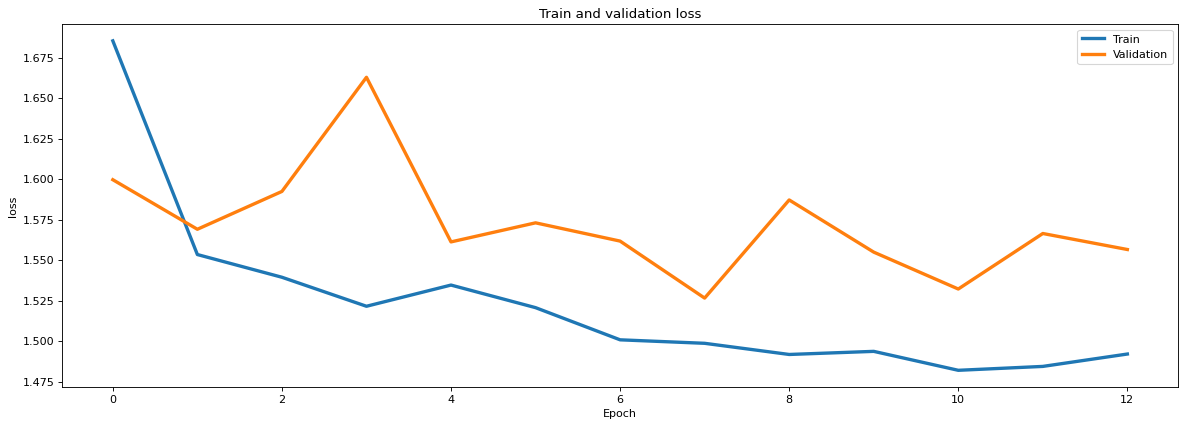

In [26]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')    
plt.plot(history['loss'],linewidth=3)
plt.plot(history['val_loss'],linewidth=3)
plt.title(f'Train and validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

## Accuracy

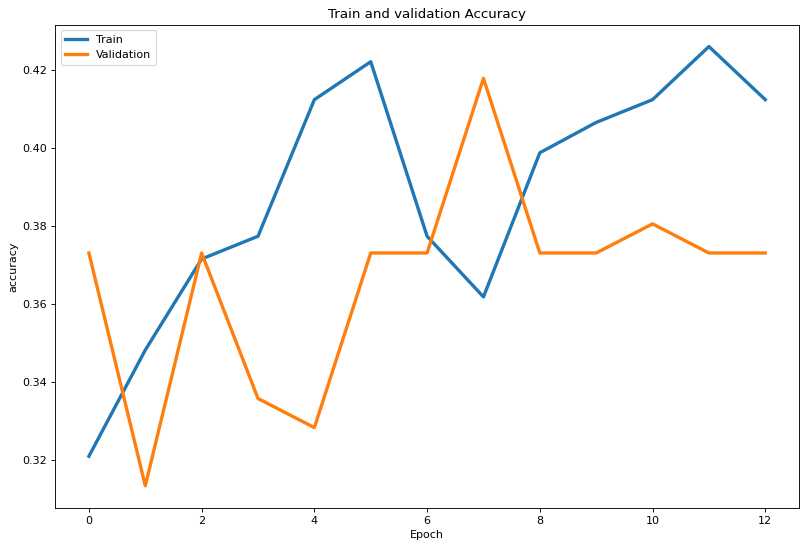

In [27]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')    
plt.plot(history['accuracy'],linewidth=3)
plt.plot(history['val_accuracy'],linewidth=3)
plt.title(f'Train and validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

  ### Confusion matrix for Test

In [28]:
y_true = []
y_pred = []
for i in range(0,len(test_generator)):
    y_true = [*y_true, *[i for i in np.argmax(test_generator[i][1],axis=1)]]    
    y_pred = [*y_pred, *[i for i in np.argmax(model.predict_on_batch(test_generator[i][0]),axis=1)]]      

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


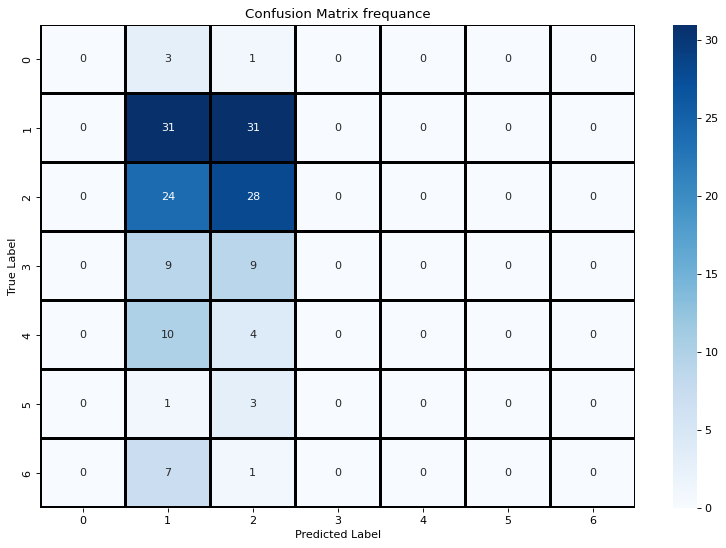

In [30]:
matrix = metrics.confusion_matrix(y_true, y_pred)            
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')        
ax = sns.heatmap(matrix,cmap="Blues",linecolor='black',linewidths=1.7,xticklabels=groups, yticklabels=groups, annot=True,fmt="d")    
plt.title("Confusion Matrix frequance")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

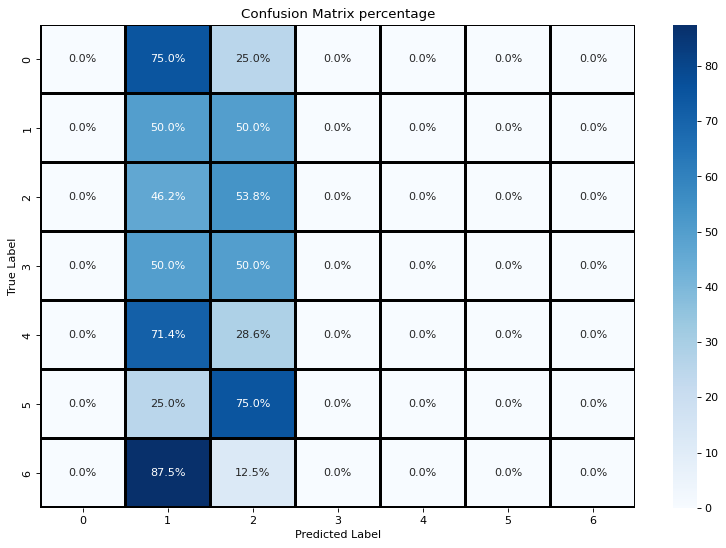

In [31]:
sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')        
ax = sns.heatmap(sensitivity,cmap="Blues",linecolor='black',linewidths=1.7,xticklabels=groups, yticklabels=groups, annot=True,fmt=".1f")    
plt.title("Confusion Matrix percentage")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
for t in ax.texts: t.set_text(t.get_text() + "%")
plt.show()

In [33]:
print(classification_report(y_true, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         4
           1     0.3647    0.5000    0.4218        62
           2     0.3636    0.5385    0.4341        52
           3     0.0000    0.0000    0.0000        18
           4     0.0000    0.0000    0.0000        14
           5     0.0000    0.0000    0.0000         4
           6     0.0000    0.0000    0.0000         8

    accuracy                         0.3642       162
   macro avg     0.1040    0.1484    0.1223       162
weighted avg     0.2563    0.3642    0.3008       162



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
